# De Novo Drug Design with AI

In this last section of the tutorial, we will show how we can generate new compounds with artificial intelligence (AI). Historically, [there have been many attempts](https://doi.org/10.3390/ijms22041676) to develop an algorithm that can generate chemical entities with desirable properties. Many of the early methods relied on evolutionary aglorithms, but today deep neural networks have become very popular for this task. It is still not clear if one approach works better than the other, but in this tutorial we will use the [DrugEx package](https://github.com/CDDLeiden/DrugEx), which integrates multiple generative deep learning models and provides a framework to train them with multiple objectives. However, there are many similar models and packages out there each with its own caveats and benefits. Therefore, it is generally a good idea to combine multiple approaches in real world applications because the overlap of the generated compounds between different methodlogies is usually very small.


## Transfer Learning (Pretrained & Finetuned Model)

We will not be training a generative model from scratch in this tutorial, but instead we will use a common technique called *transfer learning*. In transfer learning, we use an already pretrained model for one task as a starting point to finetune a second model for another task. The workflow is illustrated below:



In the context of this tutorial, the pretrained model will be a large model trained on a large data set ([Papyrus](https://zenodo.org/record/7096859)). The task of this model was to observe the entirety of Papyrus data set and learn what a chemical structure looks like and be able to generate chemically valid molecules that resemble known chemistry. For this tutorial, we chose the model based on recurrent neural netoworks (RNNs). These are ususally easier to train so you can run these experiments on a regular GPU that you might have at home without too much waiting. This choice will also affect all other choices we will make in this tutorial so note that for a different model, slightly different workflow would be necessary.

This global pretrained model is not very useful for our task, however, because it will likely only be able to generate very small percentage of molecules that might have some activity on the A2A receptor. Therefore, we will use the concept of transfer learning to obtain a finetuned model that can both generate valid molecules, but make those molecules much more similar to those that we extracted previously and should be relevant to the A2A receptor. 

### Preatrained Model

First, let us start by loading and testing the pretrained model. This model is [archived on the Zenodo service](https://zenodo.org/record/7096859). There are many files archived along with the model, but at this point we only care about the `.vocab` and `.pkg` files:

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# define work directory to store data
DATA_ROOT = '/content/drive/MyDrive/DrugExDemo/' # or wherever you want the generated files to live on your GoogleDrive
import os
os.makedirs(DATA_ROOT, exist_ok=True)
os.chdir(DATA_ROOT) 

# fetch pretrained model
os.makedirs("./data/drugex/models/pretrained/", exist_ok=True)
! wget -nc -P './data/drugex/models/pretrained/' 'https://zenodo.org/record/7096859/files/DrugEx_v2_PT_Papyrus05.5.zip'
! unzip -n './data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip' -d './data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5'

# install dependencies
! git clone https://github.com/martin-sicho/drugex-demo
! pip install -r drugex-demo/requirements.txt

# verify where we are working
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ‘./data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip’ already there; not retrieving.

Archive:  ./data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip
fatal: destination path 'drugex-demo' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/martin-sicho/DrugEx-CDDG.git (to revision master) to /tmp/pip-install-g3flc1tj/drugex_3b9f226b32954426901cf19f001a9b84
  Running command git clone -q https://github.com/martin-sicho/DrugEx-CDDG.git /tmp/pip-install-g3flc1tj/drugex_3b9f226b32954426901cf19f001a9b84
  Cloning https://github.com/martin-sicho/papyrus-scaffold-visualizer.git (to revision v0.2.0) to /tmp/pip-install-g3flc1tj/papyrus-scaffold-visualizer_ac59482e583e4ba6926edf705a9ac36e
  Running command git clone -q https://

'/content/drive/MyDrive/DrugExDemo'

In [2]:
import os
from drugex.training.models import RNN
from drugex.data.corpus.vocabulary import VocSmiles

PT_MODEL_FOLDER = "data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/"
GPUS = [0] # we will use only one GPU with ID=0, but if you have more, you can list more GPU IDs here

voc = VocSmiles.fromFile(os.path.join(PT_MODEL_FOLDER, "Papyrus05.5_smiles_rnn_PT.vocab"))
pretrained = RNN(voc, is_lstm=True, use_gpus=GPUS)
pretrained.loadStatesFromFile(os.path.join(PT_MODEL_FOLDER, "Papyrus05.5_smiles_rnn_PT.pkg"))

The `RNN` model requires a vocabulary of tokens to be provided. You can open this file and see the tokens defined in it. These are the words of the SMILES language that we use to define structures of molecules. What the model learned is how to combine these words into viable sentences (chemical structures) in the SMILES language. The data saved in the `.pkg` file are the weights (learned states) of the model that define the learned parameters and tell the model how to combine the tokens in the vocabulary in the correct way to generate a random compound that resembles known chemistry.

At this point, we should have the pretrained model loaded and be ready to generate some molecules with it. We can validate that the model functions as expected by sampling a small number of molecules from it:

In [3]:
from drugex.utils import canonicalize_list
from drugex.training.scorers.smiles import SmilesChecker
import numpy as np

def sample_smiles(self, num_smiles, batch_size=100, drop_duplicates=True, drop_invalid=True):
    smiles = []
    while len(smiles) < num_smiles:
        # sample SMILES
        sequences = self.sample(batch_size)
        # decode according to vocabulary
        new_smiles = canonicalize_list([self.voc.decode(s, is_tk = False) for s in sequences])
        # drop duplicates
        if drop_duplicates:
            new_smiles = np.array(new_smiles)
            new_smiles = new_smiles[np.logical_not(np.isin(new_smiles, smiles))]
            new_smiles = new_smiles.tolist()
        # drop invalid smiles
        if drop_invalid:
            scores = SmilesChecker.checkSmiles(new_smiles, frags=None).ravel()
            new_smiles = np.array(new_smiles)[scores > 0].tolist()
        smiles += new_smiles
    return smiles[:num_smiles]

smiles_pretrained = sample_smiles(pretrained, 1000)
print(smiles_pretrained[0:10])

['OCc1nc(Cc2ccc(O)c3nc(O)c(O)nc23)n(-c2ccc(F)cc2)c1C(O)F', 'C#Cc1ccc(-c2nc(O)c3ccc4c(c3n2)C(C)(C)CC4)c(C)c1', 'CCC(=O)c1c(O)cccc1OC', 'CC(C)CC(N)c1csc(Nc2ccc(S(N)(=O)=O)cc2)n1', 'COc1ccc(-c2csc(NC(=O)C3CCCCN3C(=O)c3ccc(C(=O)NO)cc3)n2)cc1', 'Cc1ccc(C(=O)c2c(O)c(O)n(Cc3cccnc3)c2-c2cccs2)cc1', 'Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)nn2C1CCC1', 'CCOc1cc(CNCc2cccnc2)ccc1OCC(=O)NC(C)(C)C', 'CCc1cccc(C)c1NS(=O)(=O)c1cc2c(cc1C)N(C)CCO2', 'CC(C)(C)c1[nH]nc2c1C(c1ccccc1OCCO)N(c1ccc(-c3ccsc3)cc1)C2=O']


These are the first ten SMILES strings from the 1000 requested. It is a little hard to read into the structures from the SMILES strings so let's convert them to the `scaffviz` data set, which we can use to make a visualization:

In [4]:
from scaffviz.data.dataset import DataSetSMILES

dataset = DataSetSMILES("data/pretrained_sampled.tsv", smiles=smiles_pretrained, use_existing=False)
dataset.asDataFrame().head(3)

,SMILES,RDMol
0,OCc1nc(Cc2ccc(O)c3nc(O)c(O)nc23)n(-c2ccc(F)cc2...,<rdkit.Chem.rdchem.Mol object at 0x7f3c4b02ba30>
1,C#Cc1ccc(-c2nc(O)c3ccc4c(c3n2)C(C)(C)CC4)c(C)c1,<rdkit.Chem.rdchem.Mol object at 0x7f3c4b02bb20>
2,CCC(=O)c1c(O)cccc1OC,<rdkit.Chem.rdchem.Mol object at 0x7f3c4b02bb70>


You can see that the generated `DataFrame` also includes a picture of the structure, but plotting the full chemical space plot is easy so let's do that too:

In [5]:
from scaffviz.depiction.plot import Plot
from scaffviz.clustering.manifold import TSNE
from scaffviz.clustering.descriptors import MorganFP

dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

# make an interactive plot that will use t-SNE to embed the data set in 2D (all current descriptors in the data set will be used)
plt = Plot(dataset, TSNE())

# start the server, you can open the plot in the browser
plt.plot(
    recalculate=False,
    viewport_height=800,
    port=9292
)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<IPython.core.display.Javascript object>

If we compare this plot to the plots generated in previous tutorials, we will notice that there are no clusters of points here. The compounds are spread out more or less evenly around the center of the plot. This is to be expected because the pretrained model is designed to make generally drug-like chemistry and should not be biased towards a particular group of compounds. 

### Finetuned Model

Generating more concrete and more defined chemical space will be the task for the finetuned model, which we will train with transfer learning. The task will be to generate structures that resemble more the structures in our A2A data set introduced previously:

In [6]:
import pandas as pd

df_ptp1b = pd.read_table('data/PTP1B_LIGANDS.tsv')
df_ptp1b

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Descriptor_MorganFP_1016,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023,TSNE_1,TSNE_2
0,AADVGRCQGZZZNH_on_P18031_WT,High,ChEMBL30,CHEMBL363338;44397840;CHEMBL363338;44397840;CH...,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,AADVGRCQGZZZNH,AADVGRCQGZZZNH-UHFFFAOYSA-N,InChI=1S/C45H47F2N3O10/c1-27(2)22-30(41(48)53)...,"""AuxInfo=1/1/N:1,3,37,36,38,49,56,48,55,35,39,...",P18031_WT,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,29.735216,-4.313994
1,AAGZFGSRAZMRCS_on_P18031_WT,High,ChEMBL30,CHEMBL511000;CHEMBL511000;44563281;CHEMBL51100...,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,AAGZFGSRAZMRCS,AAGZFGSRAZMRCS-UHFFFAOYSA-N,InChI=1S/C37H53NO4/c1-32(2)18-20-37(31(42)38-2...,"""AuxInfo=1/1/N:1,3,34,35,28,22,40,12,17,11,18,...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.945723,55.179680
2,AATACZKOPAGNPL_on_P18031_WT,High,ChEMBL30,CHEMBL4160013,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,AATACZKOPAGNPL,AATACZKOPAGNPL-UHFFFAOYSA-N,InChI=1S/C18H16N2O6S/c1-2-24-12-4-6-13(7-5-12)...,"""AuxInfo=1/0/N:1,2,24,5,27,6,26,23,18,11,17,4,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.630247,-24.217190
3,AAWBMDOJDQKGGQ_on_P18031_WT,High,ChEMBL30,CHEMBL3759405,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,AAWBMDOJDQKGGQ,AAWBMDOJDQKGGQ-UHFFFAOYSA-N,InChI=1S/C25H22N4O2/c1-2-14-30-19-12-10-17(11-...,"""AuxInfo=1/0/N:1,2,25,24,11,26,23,10,12,7,30,6...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.455896,-43.069510
4,ABDQNRCWGSGNBQ_on_P18031_WT,High,ChEMBL30,CHEMBL197929,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,ABDQNRCWGSGNBQ,ABDQNRCWGSGNBQ-UHFFFAOYSA-N,"InChI=1S/C21H20F2NO8PS2/c22-21(23,33(27,28)29)...","""AuxInfo=1/1/N:31,30,16,27,17,26,7,35,8,34,32,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.058834,5.535724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,ZZLZHWBNIIKVOG_on_P18031_WT,High,ChEMBL30,CHEMBL3974642;CHEMBL3903731;CHEMBL3974642;CHEM...,CC(C)CC(c1c(O)c(C=O)c(O)c(C=O)c1O)C1CCC(C)C2(C...,ZZLZHWBNIIKVOG,ZZLZHWBNIIKVOG-UHFFFAOYSA-N,InChI=1S/C28H38O5/c1-14(2)11-17(22-24(32)18(12...,"""AuxInfo=1/0/N:1,3,23,32,33,25,21,20,27,28,4,1...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.197739,21.740646
1768,ZZQGXJVGZKQIGN_on_P18031_WT,High,ChEMBL30,CHEMBL3402418,O=C(OC1CSSC1)c1ccc(CCCCCCOC(=O)c2c(Br)ccc(Br)c...,ZZQGXJVGZKQIGN,ZZQGXJVGZKQIGN-UHFFFAOYSA-N,InChI=1S/C23H24Br2O4S2/c24-18-10-11-21(25)20(1...,"""AuxInfo=1/0/N:15,16,14,17,13,11,30,10,31,26,2...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-11.149357,-5.444707
1769,ZZTBNXDDDGFULL_on_P18031_WT,High,ChEMBL30,CHEMBL1778901,CCCCOc1ccc(C(=O)C=Cc2c(OC)cc(O)c(Br)c2)cc1,ZZTBNXDDDGFULL,ZZTBNXDDDGFULL-UHFFFAOYSA-N,InChI=1S/C20H21BrO4/c1-3-4-11-25-16-8-5-14(6-9...,"""AuxInfo=1/0/N:1,17,2,3,8,24,13,7,25,12,4,23,1...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-35.552700,-15.787386
1770,ZZTYPLSBNNGEIS_on_P18031_WT,High,ChEMBL30,CHEMBL486986,CC1CCC2(C(=O)O)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C...,ZZTYPLSBNNGEIS,ZZTYPLSBNNGEIS-UHFFFAOYSA-N,InChI=1S/C30H48O4/c1-18-10-15-30(24(32)33)17-1...,"""AuxInfo=1/1/N:1,24,25,18,12,30,33,14,15,3,27,...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.356204,52.808704


There is a lot of data in this table, but for our transfer learning exercise only the SMILES are important:

In [7]:
smiles_train = df_ptp1b.SMILES
smiles_train

0       CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...
1       CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...
2           CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1
3       CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...
4       O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...
                              ...                        
1767    CC(C)CC(c1c(O)c(C=O)c(O)c(C=O)c1O)C1CCC(C)C2(C...
1768    O=C(OC1CSSC1)c1ccc(CCCCCCOC(=O)c2c(Br)ccc(Br)c...
1769           CCCCOc1ccc(C(=O)C=Cc2c(OC)cc(O)c(Br)c2)cc1
1770    CC1CCC2(C(=O)O)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C...
1771    CC(C)(C)OC(=O)COc1ccc(CC2=C(c3ccccc3)c3ccccc3C...
Name: SMILES, Length: 1772, dtype: object

In order to train the finetuned model, we need to first standardize and prepare the SMILES strings. DrugEx has its own utility to do that for all its models:

In [8]:
from drugex.data.processing import Standardization

N_PROCESSES = 12 # number of CPU cores to use
CHUNK_SIZE = 1000 # largest chunk per CPU core (regulates RAM usage)

standardizer = Standardization(n_proc=N_PROCESSES, chunk_size=CHUNK_SIZE)
smiles_train = standardizer.apply(smiles_train)
smiles_train[0:10]

Standardizing molecules (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

['CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=O)C(CCC(=O)OCc1ccccc1)NC(=O)OCC1c2ccccc2-c2ccccc21)C(N)=O',
 'CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C2C1',
 'CCOc1ccc(OC(=O)CSc2nnc(-c3ccc(O)c(O)c3)o2)cc1',
 'CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)n2)cc1',
 'O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O)O)cc2)Cc2cccs2)cc1',
 'CCOS(=O)(=O)C=Cc1ccc(OCCCCNc2nc(-c3ccc(Br)cc3)cs2)cc1',
 'CCOc1cc(NS(C)(=O)=O)c(OCC)cc1CNC(=O)Nc1ccc(C)cc1',
 'O=C(O)c1ccc(N2C(=O)C(=CC=Cc3ccccc3)SC2=S)cc1',
 'CC(C)=CCc1cc(C2CC(=O)c3ccc(O)cc3O2)cc2c1OC(C)(C)C(O)C2',
 'O=C(O)C(Cc1ccccc1)Oc1ccc(-c2ccc(-c3c(Cc4ccccc4)sc4ccccc34)cc2)cc1Br']

We write the list of SMILES back into `smiles_train` because we will not need the original SMILES anymore and proceed to generate our training data sets. In this step, the so called 'corpus' data set is generated that is nothing more than the SMILES seperated into words/tokens according to the given vocabulary. You can check out the `ligand_corpus.tsv` for yourself and see there really is nothing too special about it. The code is a little verbose, but that comes mostly from the way the data is handled by parallel processes to take advantage of multiple CPUs:

In [9]:
from drugex.data.processing import CorpusEncoder, RandomTrainTestSplitter
from drugex.data.corpus.corpus import SequenceCorpus
from drugex.data.datasets import SmilesDataSet
from drugex.logs import logger
logger.setLevel('ERROR')

DATA_DIR = "data/drugex/sets/"
os.makedirs(DATA_DIR, exist_ok=True)

voc = VocSmiles.fromFile("data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/Papyrus05.5_smiles_rnn_PT.vocab")
encoder = CorpusEncoder( # CorpusEcoder uses the supplied corpus class to encode tokens for the new data set
    SequenceCorpus, # The corpus class implements how each SMILES string is divided into words by the vocabulary
    {
        # arguments of the SequenceCorpus
        'vocabulary': voc, # used vocabulary
        'update_voc': False, # if False, the vocabulary stays fixed (no new tokens are added to it)
        'throw': True # compounds containing unknown tokens are thrown out of the resulting data set

    },
    n_proc=N_PROCESSES,
    chunk_size=CHUNK_SIZE
)

data_collector = SmilesDataSet(os.path.join(DATA_DIR, 'ligand_corpus.tsv'), rewrite=True)
encoder.apply(smiles_train, collector=data_collector)

SequenceCorpus (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

In this scenario, we will also compile a test/validation set of compounds. This will help us identify when the model starts to loose its ability to generate diverse and/or valid chemistry and begins overfitting on the training set. While we do want the generated structures to look like those in the training data, we also do not want them to be exactly the same. The validation set will serve as an indicator of such behaviour and the model will know to stop the training once the performance starts to deteriorate. 

In this case, we choose to select 10% (or a maximum of 10,000) compounds to the test set. We save the training and test set to separate files and we also save the vocabulary for safe keeping (we did not modify the original vocabulary in any way, but it is a good idea to save it anyway for future reference): 

In [10]:
splitter = RandomTrainTestSplitter(0.1, 1e4)
train, test = splitter(data_collector.getData())
for df, name in zip([train, test], ['train', 'test']):
    df.to_csv(os.path.join(DATA_DIR, f'ligand_{name}.tsv'), header=True, index=False, sep='\t')

voc.toFile(os.path.join(DATA_DIR, 'ligand.vocab'))

Now, we wrap our training and test set to `SmilesDataSet` instances so that we can generate data loaders for training:

In [11]:
BATCH_SIZE = 256

data_set_train = SmilesDataSet(os.path.join(DATA_DIR, 'ligand_train.tsv'), voc=voc)
data_set_train.voc = voc
train_loader = data_set_train.asDataLoader(batch_size=BATCH_SIZE)

data_set_test = SmilesDataSet(os.path.join(DATA_DIR, 'ligand_test.tsv'), voc=voc)
data_set_test.voc = voc
valid_loader = data_set_test.asDataLoader(batch_size=BATCH_SIZE)

Data loaders are a data structure used by [PyTorch](https://pytorch.org/) library for deep learning, which DrugEx uses to handle data and define models. They are responsible for batching the data so that it can be offloaded to the GPU for training because the whole data set would not be able to fit. In addition, batch size is an important hyperparameter in neural networks. The training does not proceed sample by sample, but rather the model processes each batch at a time and adjusts its parameters only after passing the whole batch through the network. This helps to save computational resources, but also affects the training process because it sometimes also has influence on how often and how significantly the model parameters are adjusted. Therefore, choosing the correct batch size is someting we might want play around with during training.

Another term commonly used in the language of neural networks is an 'epoch'. It is simply one iteration of training during which the model goes through all the batches and, thus, the whole data set. It is usual after each epoch that we evaluate the performance of the model and decided if it needs further training or not. In this case, we setup our training as follows:

In [12]:
from drugex.training.monitors import FileMonitor

MODEL_DIR = "data/drugex/models/finetuned/"

ft_path = os.path.join(MODEL_DIR, 'ligand_finetune')
finetuned = RNN(voc, is_lstm=True, use_gpus=GPUS)
finetuned.loadStatesFromFile(os.path.join(PT_MODEL_FOLDER, 'Papyrus05.5_smiles_rnn_PT.pkg'))
monitor = FileMonitor(ft_path, verbose=True)
finetuned.fit(train_loader, valid_loader, epochs=10, monitor=monitor)

voc.toFile(os.path.join(MODEL_DIR, 'finetune.vocab'))

Facilitating transfer learning in this case is easy. We load the pretrained model just like we did above, but instead of generting smiles with it, we call the `fit` method and supply the finetuning data loaders. We set the number of epochs to 10 in this case. Training should not take more than an hour in this case even on an older GPU. On an NVIDIA RTX 2070 this took only a few minutes.

We also set up a training monitor (`FileMonitor`), which saves some improtant data during training. You will find these files in the `MODEL_DIR` directory with the `ligand_finetune` perfix. The following file saves the training and validation loss (`loss_train` and `loss-valid`, respectively). In simple terms, the losses indicate how well the model is able to capture the probability distribution of tokens in either the training set or the test set with the compounds it generates at each epoch. We also get information about the percentage of valid SMILES it produces (`valid_ratio`). There are also some empty values that are not relevant at the moment, but will come into play later. We can load the table as any other data file:

In [13]:
df_info = pd.read_csv('data/drugex/models/finetuned/ligand_finetune_fit.tsv', sep='\t')
df_info.head()

,epoch,loss_train,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,0.150419,0.177394,1.000000,NaN,NaN,NaN
1,2,0.169526,0.168819,0.846154,NaN,NaN,NaN
2,3,0.136890,0.165448,0.923077,NaN,NaN,NaN
3,4,0.118591,0.164929,0.923077,NaN,NaN,NaN
4,5,0.112708,0.163556,1.000000,NaN,NaN,NaN


We can also plot everything quite easily:

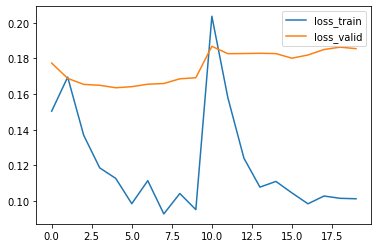

In [14]:
df_info[['loss_train', 'loss_valid']].plot.line()

We can see that while the training loss is going down during training the validation loss starts to dwindle and even increases slightly. This indicates that our model is starting to overfit the training set a little so we might want to think about tweaking the parameters a little bit here. However, it is OK for the purpose of our tutorial and as we will see, even such a short round of transfer learning had an effect on our model. We can show that by sampling another set of SMILES with this model and showing the chemical space plot:

In [15]:
finetuned.loadStatesFromFile('data/drugex/models/finetuned/ligand_finetune.pkg')

smiles_finetuned = sample_smiles(finetuned, 1000)

dataset = DataSetSMILES("data/finetuned_sampled.tsv", smiles=smiles_finetuned, use_existing=False)
dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

plt = Plot(dataset, TSNE())
plt.plot(
    recalculate=False,
    viewport_height=800,
    port=9393
)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



<IPython.core.display.Javascript object>

When we compare this chemical space to the space generated with the pretrained model above, it is clear that these compounds are differently distributed and if we take a look at the structures we might be able to spot some patterns commonly seen in adenosine receptor ligands, which means that the transfer learning did seem to work.

### Optimizing Compound Properties with Reinforcement Learning

We now successfully used transfer learning to create a model that can generate new molecules that resemble known data. That is very nice, but not often useful. Consider for example a case of a pharmaceutical company that is trying to develop a new drug, which has not been published or patented, yet. It is unlikely that with this model, we will be able to find completely new scaffolds. All it can do is copy and mimick known chemical space related to adenosine receptor A2A. It also has no information about activity of the compounds. It just creates new molecule that look like the known ligands. But what if we could create a model that can generate structures that are more likely to be binders than nonbinders of the A2A receptor? We will explain how to do exactly that in this chapter.

Reinforcement learning is a well-known concept in machine learning and AI and can be used to train neural networks to successfully accomplish various tasks. The most famous example is [AlphaGo](https://en.wikipedia.org/wiki/AlphaGo), a machine learning model that was trained to successfully play the borad game Go, but there are also models that learned to [walk](https://arxiv.org/pdf/1812.11103.pdf), [play computer games](https://www.theverge.com/2018/8/6/17655086/dota2-openai-bots-professional-gaming-ai) or many [other things](https://rl-book.com/applications/). This is a simple schematic that illustrates the idea of reinforcement learning:


Regardless of whether the AI is learning to walk or generate molecules, the concept is the same. The model acts as an *agent* in the *environment*. The agent performs an *action* in the environment (i.e. generates a molecular structure). Based on the action, the agent then receives a *reward* from an *interpreter* (i.e. a QSAR model predicting activity on the A2A receptor). The obtained reward can then be used to adjust the actions made by the agant, for example by changing it's *state* (i.e. the weights of the neural network). This loop is repeated until the agent learns to walk, play a game or generates molecules interesting for us. 

In this tutorial, we will teach our model (*agent*) to generate more active and synthetically accessible molecules. That means we will have two *observers* in our environment that will each give feedback to our models. This is called multi-objective optimization and reflects more the way we think about 'good molecules' in drug discovery. It is not always just perceived activity that is important, but other criteria like synthetic accessibility play an important role too.

#### Observer 1 (The QSAR Model)

Therefore, the first of our observers (or more often scoring functions) will be the QSAR model we trained previously. It will provide the *agent* with information about the likely activity agains A2A receptor:

In [16]:
import joblib

model = joblib.load('data/qsar/models/PTP1B_CLS_ET_250.pickle')
model

ExtraTreesClassifier(n_estimators=250)

In order to feed this model to our DrugEx agent, we need to wrap it in the `Scorer` interface:

In [17]:
from drugex.training.interfaces import Scorer

class ModelScorer(Scorer):
    
    def __init__(self, model, prefix, descriptor = MorganFP(radius=2, nBits=1024)):
        super().__init__()
        self.model = model
        self.prefix = prefix
        self.descriptor = descriptor
    
    def getScores(self, mols, frags=None):
        X = pd.Series(mols).apply(lambda x : pd.Series(self.descriptor(x) if x else [0] * 1024))
        preds = self.model.predict_proba(X)[::,1]
        return preds
    
    def getKey(self):
        return f"{self.prefix}_MS"



scorer_model = ModelScorer(model, 'PTP1B_CLS')
scorer_model

A scorer is a simple Python class that needs to have the `getScores` and `getKey` methods. The `getScores` method is the most important one and is used to calculate scores (model predictions) for the generated molecules at each epoch of training. The `getKey` method just gives the scorer a unique name that will appear in the outputs and will be used by the model.

We can illustrate how the scorer functions by feeding it our list of smiles from the finetuned model:

In [18]:
predictions = scorer_model(smiles_finetuned)
predictions[0:10]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names



array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.024, 0.02 , 0.008,
       0.032])

We can also calculate the percentage of molecules that would be classified as active at this point. It is just molecules for which the predicted value is more than 0.5:

In [19]:
sum(predictions > 0.5) / len(predictions)

0.023

Therefore, almost half of the generated molecules are perceived as likely binders by our model. Not bad for such a simple model. But let's see if we can further improve this ration with reinforcement learning.

#### Observer 2 (Synthetic Accessibility Score)

Our second observer in this experiment will be the [Synthetic Accessibility Score](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-1-8) (SAScore). It has been around for a long time and is generally considered as a reasonable measure of how complex (hard to synthesize) a compound structure is. It is available in DrugEx and we can easily create this scoring function as follows:

In [20]:
from drugex.training.scorers.properties import Property

sascore = Property("SA")

#### Desirability Score Modifiers

Because the scorers that we created above each work on a different scale, it might be a good idea to normalize them somehow and make them work on the same scale and express to the model what values of the scores are actually desirable and what are not. For example, we want the SAScore as low as possible while we want the score from the model as close to 1 as possible (have the most confidence in the prediction that the generated compounds are active). This where the desirability modifier comes in. It helps us to keep things on one scale while telling the model what distribution of scores is good for us.

For the QSAR model, we will choose the `ClippedScore` modifier:

In [21]:
from drugex.training.scorers.modifiers import ClippedScore

scorer_model.setModifier(ClippedScore(lower_x=0.2, upper_x=0.8))

With this modifier we are telling the agent that molecules with scores that are less than 0.2 are no good for us while scores of more than 0.8 are good with some linear progressin in between. We can easily visualize the modifier with the following code:

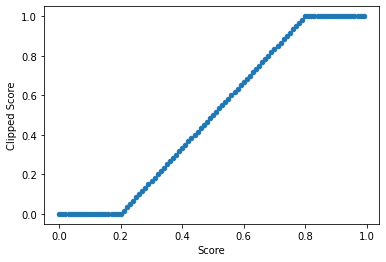

In [22]:
import numpy as np

def depict_modifier(modifier, start=0, end=1, step=0.01, name = 'Clipped Score'):
    vals = np.arange(start,end, step)
    scores = [(x, modifier(x)) for x in vals] # get the A1R modifier for inactivity (the lower the activity, the higher the reward)
    scores = pd.DataFrame(scores, columns=['Score', name])
    return scores.plot.scatter(x = 'Score', y = name)

depict_modifier(scorer_model.getModifier())

As we can see the agent will be told to stay away from molecules of scores lower then 0.2 and move towards molecules of at least score 0.8. The reason for the linear progression in between is there so that the model can evaluate whether one molecule is better than the other, but not generally desired.

For the SAScore we will opt for the smoothed out variant of clipped score, `SmoothClippedScore`:

In [23]:
from drugex.training.scorers.modifiers import SmoothClippedScore

sascore.setModifier(SmoothClippedScore(lower_x=5, upper_x=3))

This funtion looks as follows:

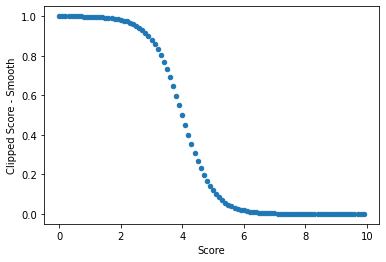

In [24]:
depict_modifier(sascore.getModifier(), 0, 10, 0.1, 'Clipped Score - Smooth')

In general, molecules with SAScore higher than 6 are considered quite complex, but can still be present in data sets so we give the distribution a more gradual decrease with a longer right tail. We will also never achieve the perfect SAScore of 1, but that is OK as long as we tell the model we want the score as close to one as possible.

#### The Environment

The last thing we have to do is to create the environment and to specify desirability thresholds for our scoring functions. We also need to apply a suitable multi-objective reward scheme:

In [25]:
from drugex.training.environment import DrugExEnvironment
from drugex.training.rewards import ParetoCrowdingDistance

scorers = [
    scorer_model,
    sascore
]
thresholds = [
    0.5,
    0.1
]

environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())

The thresholds can play some role in some reward schemes (i.e. `WeightedSum`), but in this case they will just be used to deem whether a molecule is desirable or not. We can show what that means if we get the scores for our previously generated compounds with the environment: 

In [26]:
scores = environment.getScores(smiles_finetuned)
scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names



,PTP1B_CLS_MS,SA,DESIRE,VALID
0,0.0,0.164636,0,1
1,0.0,0.970300,0,1
2,0.0,0.906671,0,1
3,0.0,0.943109,0,1
4,0.0,0.688849,0,1
...,...,...,...,...
995,0.0,0.445059,0,1
996,0.0,0.761184,0,1
997,0.0,0.568844,0,1
998,0.0,0.755893,0,1


The `DESIRE` column shows a 1 for all molecules that satisfy the desirability thresholds for all objectives (SAScore higher than 0.1 and the predicted active probability from QSAE of more than 0.5). Note that the thresholds relate to the modified scores and not the original values.

We can now calculate how many desirable compounds there are in this initial set:

In [27]:
sum(scores["DESIRE"]) / len(scores)

0.023

We can also analyze the distribution of the score for each objective:

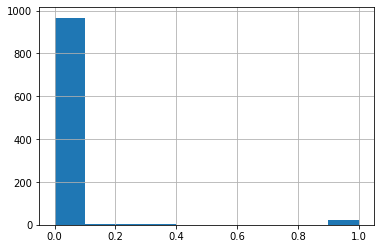

In [29]:
scores.PTP1B_CLS_MS.hist()

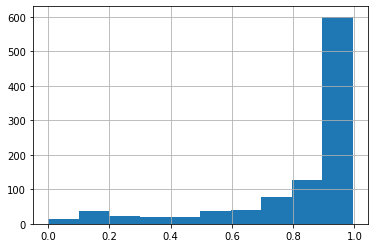

In [30]:
scores.SA.hist()

We can see that this is not bad for just an initial model, but we can surely do better, especially when it comes to biological activity predictions. Let's see if we can manage that with reinforcement learning. For the RNN model, the reinforcement learning framework is implemented with the `SmilesExplorerNoFrag` class:

In [31]:
from drugex.training.models.explorer import SmilesExplorerNoFrag
import warnings
warnings.filterwarnings('ignore')

pretrained = RNN(voc, is_lstm=True, use_gpus=GPUS)
pretrained.loadStatesFromFile('data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/Papyrus05.5_smiles_rnn_PT.pkg')

finetuned = RNN(voc, is_lstm=True, use_gpus=GPUS)
finetuned.loadStatesFromFile('data/drugex/models/finetuned/ligand_finetune.pkg')

explorer = SmilesExplorerNoFrag(
    agent = finetuned,
    env = environment,
    mutate = pretrained, # network introducing mutations to the generated structures (rate determined by epsilon)
    epsilon = 0.01,
    use_gpus = GPUS
)

There are quite a few things we can tweak about the explorer here and the way it approaches reinforcement learning. We could for example choose the pretrained network to be the agent instead of the finetuned network. Doing that could help us find more novel structures that are also active. When using the finetuned model as the agent, the structures will be more similar to known ligands. In our current scenario, we are also using a rather low exploration parameter (`epsilon`), which is another way to influence the diversity of the generated compounds. The higher the `epsilon`, the larger the influence of the mutations introduced by the pretrained model, which adds more randomness to our structures. In short, there is a lot of space for experimentation and you can read more information in the [original paper](https://doi.org/10.1186/s13321-019-0355-6). In this particular case, we just chose the easiest setup for the algorithm so that it converges more easily and we can train it faster, but at the expense of more diverse exploration of chemical space.

With that said, let's get to training. Thanks to this simplified setup, 30 epochs should be enough for us to already see a result:

In [32]:
monitor = FileMonitor(os.path.join(MODEL_DIR, 'ligand_agent_rl'), verbose=True)
explorer.fit(train_loader, valid_loader, monitor=monitor, epochs=30)

Again, we can observer the evolution of certain parameters during training. Most improtantly the validity of the generated structures and the training loss:

In [33]:
df_info = pd.read_csv('data/drugex/models/finetuned/ligand_agent_rl_fit.tsv', sep='\t')
df_info.head()

,epoch,loss_train,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,NaN,NaN,0.843750,NaN,0.000000,-1.399064
1,2,NaN,NaN,0.890625,NaN,0.015625,-0.100912
2,3,NaN,NaN,0.906250,NaN,0.015625,-0.096067
3,4,NaN,NaN,0.937500,NaN,0.015625,-0.089189
4,5,NaN,NaN,0.921875,NaN,0.007812,-0.090883


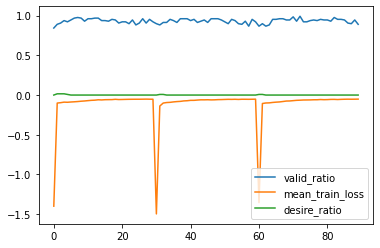

In [34]:
df_info[['valid_ratio', 'mean_train_loss', 'desire_ratio']].plot.line()

We can see that most of the compounds remain valid and the training loss also improves slightly. We also have a little drop in validity and loss after the first epoch, but the model quickly stabilizes itself. 

Let's test if this model is now able to produce better molecules. We just need to load it from the saved state and sample new structures:

In [35]:
agent = RNN(voc, is_lstm=True, use_gpus=GPUS)
agent.loadStatesFromFile('data/drugex/models/finetuned/ligand_agent_rl.pkg')

smiles_rl = sample_smiles(agent, 1000)

We can again push them through our environment and see how many of them are desirable according to our settings:

In [36]:
scores = environment.getScores(smiles_rl)
scores

,PTP1B_CLS_MS,SA,DESIRE,VALID
0,0.0,0.989798,0,1
1,0.0,0.973263,0,1
2,0.0,0.049144,0,1
3,0.0,0.835429,0,1
4,0.0,0.981537,0,1
...,...,...,...,...
995,0.0,0.937560,0,1
996,0.0,0.881334,0,1
997,0.0,0.948062,0,1
998,0.0,0.808882,0,1


In [37]:
sum(scores["DESIRE"] > 0.5) / len(scores)

0.01

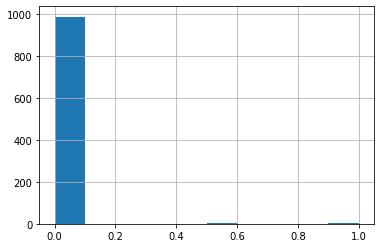

In [39]:
scores.PTP1B_CLS_MS.hist()

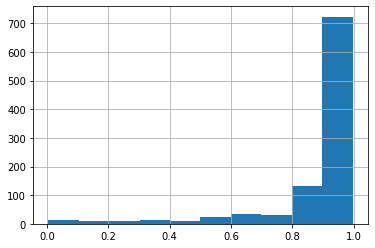

In [40]:
scores.SA.hist()

That definitely looks better than before. We now have a much higher ratio of desirable molecules. Let's take a look at the structures and use the model output to color them based on predicted activity:

In [41]:
dataset = DataSetSMILES("data/finetuned_rl_sampled.tsv", smiles=smiles_rl, use_existing=False)
dataset.addData('CLS', scores.PTP1B_CLS_MS)
dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

plt = Plot(dataset, TSNE())
plt.plot(
    recalculate=False,
    color_by='CLS',
    color_continuous_scale="rdylgn",
    color_style='continuous',
    viewport_height=800,
    port=9595
)

<IPython.core.display.Javascript object>

A lot of the molecules are lit up green, which is good. It means the model is confident that these structures belong to active ligands. It seems that we were able to improve the original model's ability to produce more active and synthetically accessible compounds. Congratulations, maybe there is a new drug in there :) 

But before jumping into conclusions we should be critical of what we accomplished here. We merely optimized the original finetuned model so it is likely there is a big overlap between the original data set and this new set of compounds. We can easily check how our compounds compare to the original set by visualizing them together:

In [42]:
df_joined = pd.concat(
    [
        pd.DataFrame(
            {'SMILES' : df_ptp1b.SMILES.tolist(), 'Group': 'PTP1B Set'}
        ),
        pd.DataFrame(
            {'SMILES' : smiles_rl, 'Group': 'Generated'}
        )
    ]
)
df_joined

,SMILES,Group
0,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,PTP1B Set
1,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,PTP1B Set
2,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,PTP1B Set
3,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,PTP1B Set
4,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,PTP1B Set
...,...,...
995,O=C(c1cccc(Cl)c1)N1CCCc2cc(C(O)CN3CCCCC3)ccc21,Generated
996,CC(=O)N1Cc2ccccc2C(C)(C)N1O,Generated
997,O=C(O)c1ccc(CN2C(=O)C(=Cc3cccc(Oc4ccccc4)c3)N2...,Generated
998,COC(=O)COC(=O)C(C)=CC(C)=Cc1csc(C(Cc2ccc(OCc3c...,Generated


In [44]:
from scaffviz.data.dataset import DataSetTSV

dataset = DataSetTSV("data/original_and_generated.tsv", data=df_joined)
dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

plt = Plot(dataset, TSNE())
plt.plot(
    recalculate=False,
    color_by='Group',
    viewport_height=800,
    port=9696
)

<IPython.core.display.Javascript object>

Indeed, there is some overlap between the original data set and the generated structures, but we also manage to generate some compounds outside of these orginal clusters. You can try to vary the `epsilon` parameter and see what happens with desirability and diversity of the molecules. However, maybe there is also some merit to this model. It all depends on the task at hand. But in any case we might want to generate even more compounds with the model and try to verify and screen the generated library with more precise methods (i.e. molecular docking).